# Importing libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Loading the dataset and Data Augmentation

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)) # Normalize the images to [-1, 1]
])

In [3]:
# Load MNIST training dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 35239716.02it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 1067886.40it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 9096254.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 3931186.29it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Load MNIST test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

In [5]:
# Create DataLoader for training set
train_loader = DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True
)

# Create DataLoader for test set
test_loader = DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False
)

# Modifying ResNet model for MNIST dataset

In [6]:
import torchvision.models as models
import torch.nn as nn

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1 channel (grayscale)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the fully connected layer for 10 output classes (MNIST)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# Move model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s] 


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Model Setup

In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model

In [8]:
# Number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print loss for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 0.1794
Epoch [2/10], Loss: 0.0733
Epoch [3/10], Loss: 0.0549
Epoch [4/10], Loss: 0.0462
Epoch [5/10], Loss: 0.0360
Epoch [6/10], Loss: 0.0336
Epoch [7/10], Loss: 0.0264
Epoch [8/10], Loss: 0.0250
Epoch [9/10], Loss: 0.0255
Epoch [10/10], Loss: 0.0238


# Testing Loop

In [11]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

Accuracy on the test set: 99.23%


# Saving the Model

In [10]:
# Save the trained model
torch.save(model.state_dict(), 'mnist_resnet18.pth')
print("Model saved successfully!")

Model saved successfully!


# PGD Adversarial Attacks onto the Model

In [8]:
!pip install torchattacks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.9.0 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you ha

In [9]:
import torchattacks
from torchattacks import PGD, CW

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model structure
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# Load the trained model weights
model.load_state_dict(torch.load('/kaggle/input/mnist_resnet18/pytorch/default/1/mnist_resnet18.pth'))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
import torchattacks
from tqdm import tqdm
import time

# Define the PGD attack
pgd = torchattacks.PGD(model, eps=0.1, alpha=2/255, steps=40)

# Function to evaluate the model under attack with a progress bar
def evaluate_under_attack(loader, model, attack):
    model.eval()
    correct = 0
    total = 0
    batch_times = []
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc="Evaluating")
    
    for i, (inputs, labels) in progress_bar:
        start_time = time.time()
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Enable gradients for the inputs
        inputs.requires_grad = True
        
        adv_inputs = attack(inputs, labels)
        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Disable gradients for the inputs
        inputs.requires_grad = False

        batch_time = time.time() - start_time
        batch_times.append(batch_time)
        
        # Update progress bar with batch accuracy and average batch time
        progress_bar.set_postfix(batch_accuracy=(correct / total), avg_batch_time=sum(batch_times) / len(batch_times))
    
    accuracy = correct / total
    return accuracy

# Evaluate the model under PGD attack
adv_accuracy = evaluate_under_attack(test_loader, model, pgd)
print(f'Adversarial Accuracy under PGD Attack: {adv_accuracy * 100:.2f}%')

Evaluating: 100%|██████████| 157/157 [01:01<00:00,  2.54it/s, avg_batch_time=0.38, batch_accuracy=0.606] 

Adversarial Accuracy under PGD Attack: 60.59%


In [13]:
import torchattacks
from tqdm import tqdm

# Define FGSM attack
fgsm = torchattacks.FGSM(model, eps=0.3)

# Function to evaluate under FGSM attack with TQDM
def evaluate_under_attack(loader, model, attack):
    model.eval()
    correct = 0
    total = 0
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc="Evaluating")
    for i, (inputs, labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Generate adversarial examples if attack is specified
        if attack:
            adv_inputs = attack(inputs, labels)
        else:
            adv_inputs = inputs
        
        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update the progress bar with current accuracy
        progress_bar.set_postfix(batch_accuracy=(correct / total))
    
    return correct / total

# Test the model under FGSM attack
accuracy_fgsm = evaluate_under_attack(test_loader, model, fgsm)
print(f'Accuracy under FGSM Attack: {accuracy_fgsm * 100:.2f}%')

Evaluating: 100%|██████████| 157/157 [00:05<00:00, 29.48it/s, batch_accuracy=0.499]

Accuracy under FGSM Attack: 49.87%


# Carlini Wagner Attack

In [15]:
import torchattacks
from tqdm import tqdm
import time

# Define the Carlini-Wagner attack
cw = torchattacks.CW(model, c=1e-3, kappa=0, steps=100, lr=0.01)

# Function to evaluate the model under CW attack with a progress bar
def evaluate_under_attack(loader, model, attack):
    model.eval()
    correct = 0
    total = 0
    batch_times = []
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc="Evaluating")
    
    for i, (inputs, labels) in progress_bar:
        start_time = time.time()
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Enable gradients for the inputs
        inputs.requires_grad = True
        
        adv_inputs = attack(inputs, labels)
        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Disable gradients for the inputs
        inputs.requires_grad = False

        batch_time = time.time() - start_time
        batch_times.append(batch_time)
        
        # Update progress bar with batch accuracy and average batch time
        progress_bar.set_postfix(batch_accuracy=(correct / total), avg_batch_time=sum(batch_times) / len(batch_times))
    
    accuracy = correct / total
    return accuracy

# Evaluate the model under CW attack
cw_accuracy = evaluate_under_attack(test_loader, model, cw)
print(f'Adversarial Accuracy under CW Attack: {cw_accuracy * 100:.2f}%')

Evaluating: 100%|██████████| 157/157 [00:30<00:00,  5.21it/s, avg_batch_time=0.176, batch_accuracy=0.798]

Adversarial Accuracy under CW Attack: 79.81%


# Visualizing All Images

## Visualizing Original Images with Labels

In [31]:
# Function to unnormalize and visualize images
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Visualize a few original dataset images with their labels
def visualize_original_images(loader, num_images=5):
    dataiter = iter(loader)
    images, labels = next(dataiter)  # Use next() to get the next batch
    images, labels = images[:num_images], labels[:num_images]
    imshow(torchvision.utils.make_grid(images), title=[str(int(label)) for label in labels])

# Visualize original images
# visualize_original_images(test_loader)

## Visualizing The Model's Predictions

In [ ]:
# Visualize the model's predictions on original images
def visualize_model_predictions(model, loader, num_images=5):
    model.eval()
    dataiter = iter(loader)
    images, labels = next(dataiter)  # Use next() to get the next batch
    images, labels = images[:num_images], labels[:num_images]
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()

    imshow(torchvision.utils.make_grid(images.cpu()), title=[str(pred) for pred in predicted])

In [ ]:
# Visualize model predictions on original images
visualize_model_predictions(model, test_loader)

## Visualizing PGD Adversarial Attacks

In [42]:
import matplotlib.pyplot as plt
import numpy as np
# Visualize adversarial examples generated by PGD attack
def visualize_pgd_attack(model, loader, attack, num_images=5):
    model.eval()
    dataiter = iter(loader)
    images, labels = next(dataiter)  # Use next() to get the next batch
    images, labels = images[:num_images], labels[:num_images]
    images, labels = images.to(device), labels.to(device)

    adv_images = attack(images, labels)
    outputs = model(adv_images)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()

    imshow(torchvision.utils.make_grid(adv_images.cpu()), title=[str(pred) for pred in predicted])

In [43]:
# Define PGD attacks
pgd = torchattacks.PGD(model, eps=1.06, alpha=6/255, steps=40)

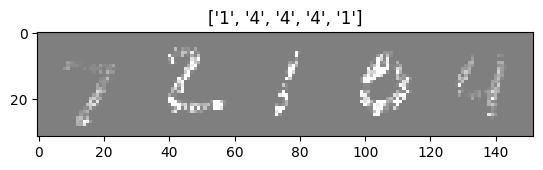

In [44]:
# Visualize PGD attack
visualize_pgd_attack(model, test_loader, pgd)

## Visualizing CW Adversarial Attacks

In [35]:
import matplotlib.pyplot as plt
# Visualize adversarial examples generated by CW attack
def visualize_cw_attack(model, loader, attack, num_images=5):
    model.eval()
    dataiter = iter(loader)
    images, labels = next(dataiter)  # Use next() to get the next batch
    images, labels = images[:num_images], labels[:num_images]
    images, labels = images.to(device), labels.to(device)

    adv_images = attack(images, labels)
    outputs = model(adv_images)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()

    imshow(torchvision.utils.make_grid(adv_images.cpu()), title=[str(pred) for pred in predicted])

In [36]:
# Define CW attacks
cw = torchattacks.CW(model, c=1e-4, kappa=0, steps=1000, lr=0.01)

In [37]:
# Visualize CW attack
visualize_cw_attack(model, test_loader, cw)

NameError: name 'np' is not defined